AER 850 Machine Learning Project
Hussein Hamie 500876254
Mishran Haque 500896460

# Turbofan Engine Remaining Useful Life Prediction
**DATASET:** NASA Turbofan Jet Engine Data Set
**By:** Hussein Hamie and Mishran Haque

# Introduction


![Image of ](https://i.postimg.cc/ZqdZ56mW/turbo-jet-engine-diagram.jpg)

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1) unit number
2) time, in cycles
3) operational setting 1
4) operational setting 2
5) operational setting 3
6) sensor measurement 1
7) sensor measurement 2
...
26) sensor measurement 26

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ‘Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation’, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

In [94]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm
import keras.models
import keras.layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import warnings
warnings.simplefilter('ignore')

In [95]:
data_train = pd.read_csv("/mnt/e/Coding/MachineLearningCourse/Project/CMaps/train_FD001.txt",sep=" ",header=None)
data_test = pd.read_csv("/mnt/e/Coding/MachineLearningCourse/Project/CMaps/test_FD001.txt",sep=" ",header=None)
data_RUL = pd.read_csv("/mnt/e/Coding/MachineLearningCourse/Project/CMaps/RUL_FD001.txt",sep=" ",header=None)

train_copy = data_train
test_copy = data_test

In [96]:
# Remove the  NaN Columns
data_train.drop(columns=[26,27],inplace=True)
data_test.drop(columns=[26,27],inplace=True)
data_RUL.drop(columns=[1],inplace=True)

In [97]:
columns_train = ['unit_ID','cycles','setting_1','setting_2','setting_3',' Total Temperature at fan inlet','Total Temperature at LPC outlet','Total Temperature HPC outlet','Total Temperature LPT outlet','Pressure at fan Inlet','Total pressure in bypass-duct','Total pressure at HPC outlet','Physcial fan speed',
           'Physical Core speed','Engine Pressure Ratio (P50/P2)','Static pressure at HPC outlet','Ratio of fuel flow to Ps30','Corrected fan speed','Corrected core speed','Bypass Ratio','Burner fuel-air ratio','Bleed Enthalpy','Demanded fan speed','Demanded corrected fan speed','HPT coolant bleed','LPT coolant bleed' ]
data_train.columns = columns_train
data_train.describe()

,unit_ID,cycles,setting_1,setting_2,setting_3,Total Temperature at fan inlet,Total Temperature at LPC outlet,Total Temperature HPC outlet,Total Temperature LPT outlet,Pressure at fan Inlet,...,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed,Demanded corrected fan speed,HPT coolant bleed,LPT coolant bleed
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [98]:
data_train

,unit_ID,cycles,setting_1,setting_2,setting_3,Total Temperature at fan inlet,Total Temperature at LPC outlet,Total Temperature HPC outlet,Total Temperature LPT outlet,Pressure at fan Inlet,...,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed,Demanded corrected fan speed,HPT coolant bleed,LPT coolant bleed
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [101]:
# Define a function to calculate the remaining useful life (RUL)
def add_rul(g):
    # Calculate the RUL as the difference between the maximum cycle value and the cycle value for each row
    g['RUL'] = max(g['cycles']) - g['cycles']
    return g

# Apply the add_rul function to the training data grouped by the unit ID
train = data_train.groupby('unit_ID').apply(add_rul)

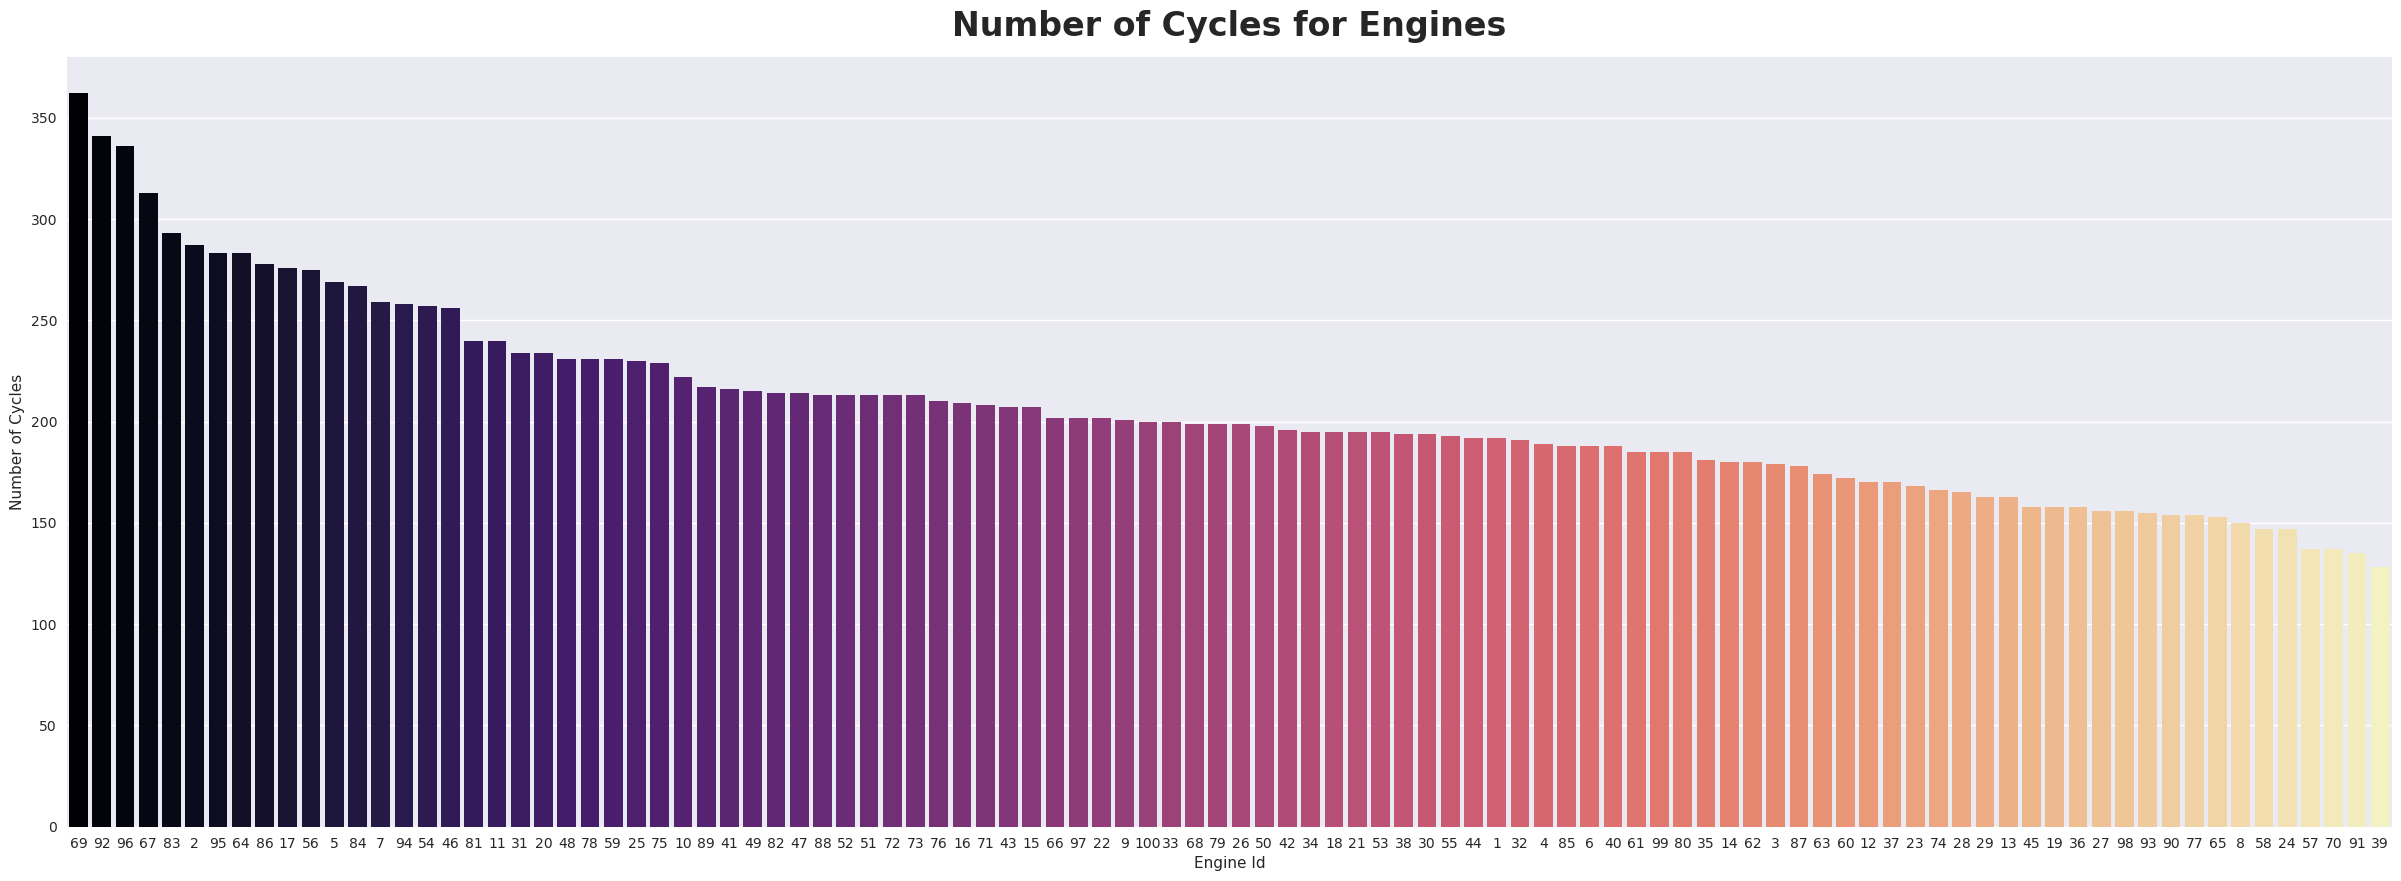

In [100]:
cnt_train = data_train[["unit_ID", "cycles"]].groupby("unit_ID").max().sort_values(by="cycles", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycles.values)

plt.style.use("seaborn")
plt.figure(figsize=(30, 10))
sns.barplot(x=list(cnt_ind), y=list(cnt_val), palette='magma')
plt.ylabel('Number of Cycles')
plt.xlabel('Engine Id')
plt.title('Number of Cycles for Engines', fontweight='bold', fontsize=24, pad=15)

plt.show()

Mean number of cycles after which jet engine fails is 206


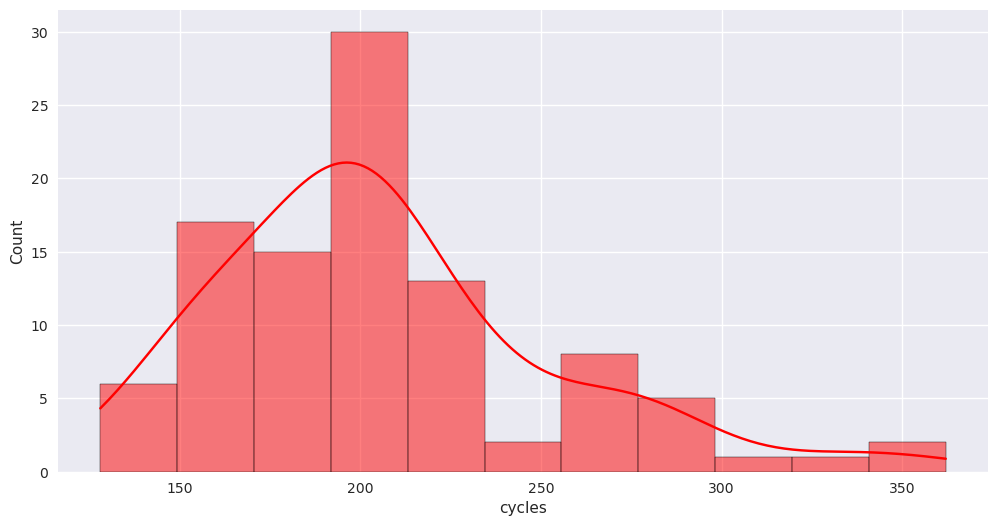

In [116]:
plt.subplots(figsize=(12, 6))
sns.histplot(cnt_train["cycles"], kde = True, color='red');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(cnt_train["cycles"].mean())))

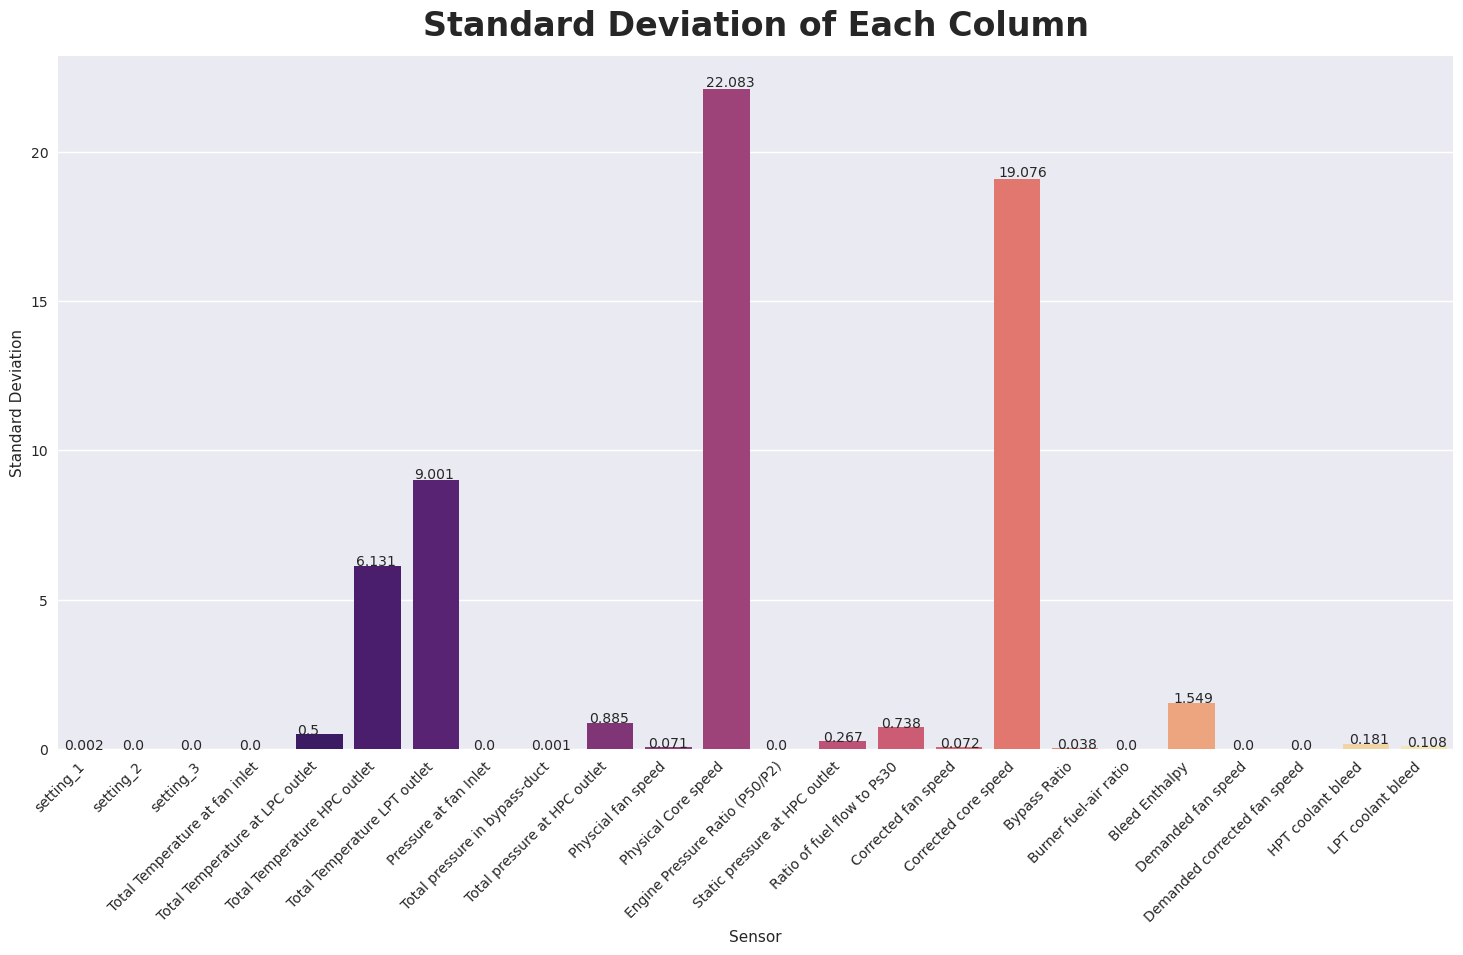

In [69]:
plt.figure(figsize=(18, 9))
subset_stats = data_train.agg(['mean', 'std']).T[2:]
ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='magma')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Sensor")
ax.set_ylabel("Standard Deviation")
ax.set_title("Standard Deviation of Each Column", fontweight='bold', fontsize=24, pad=15)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [70]:
train.drop(columns=[' Total Temperature at fan inlet','Pressure at fan Inlet','Engine Pressure Ratio (P50/P2)','Burner fuel-air ratio','Demanded fan speed','Demanded corrected fan speed'])

,unit_ID,cycles,setting_1,setting_2,setting_3,Total Temperature at LPC outlet,Total Temperature HPC outlet,Total Temperature LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,...,Physical Core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalpy,HPT coolant bleed,LPT coolant bleed,RUL
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,21.61,554.36,...,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,21.61,553.75,...,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,21.61,554.26,...,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,21.61,554.45,...,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,21.61,554.00,...,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,21.61,551.43,...,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,21.61,550.86,...,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,21.61,550.94,...,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,21.61,550.68,...,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [118]:
train2 = train.drop(columns=['setting_1','setting_2','setting_3',' Total Temperature at fan inlet','Pressure at fan Inlet','Engine Pressure Ratio (P50/P2)','Burner fuel-air ratio','Demanded fan speed','Demanded corrected fan speed'])

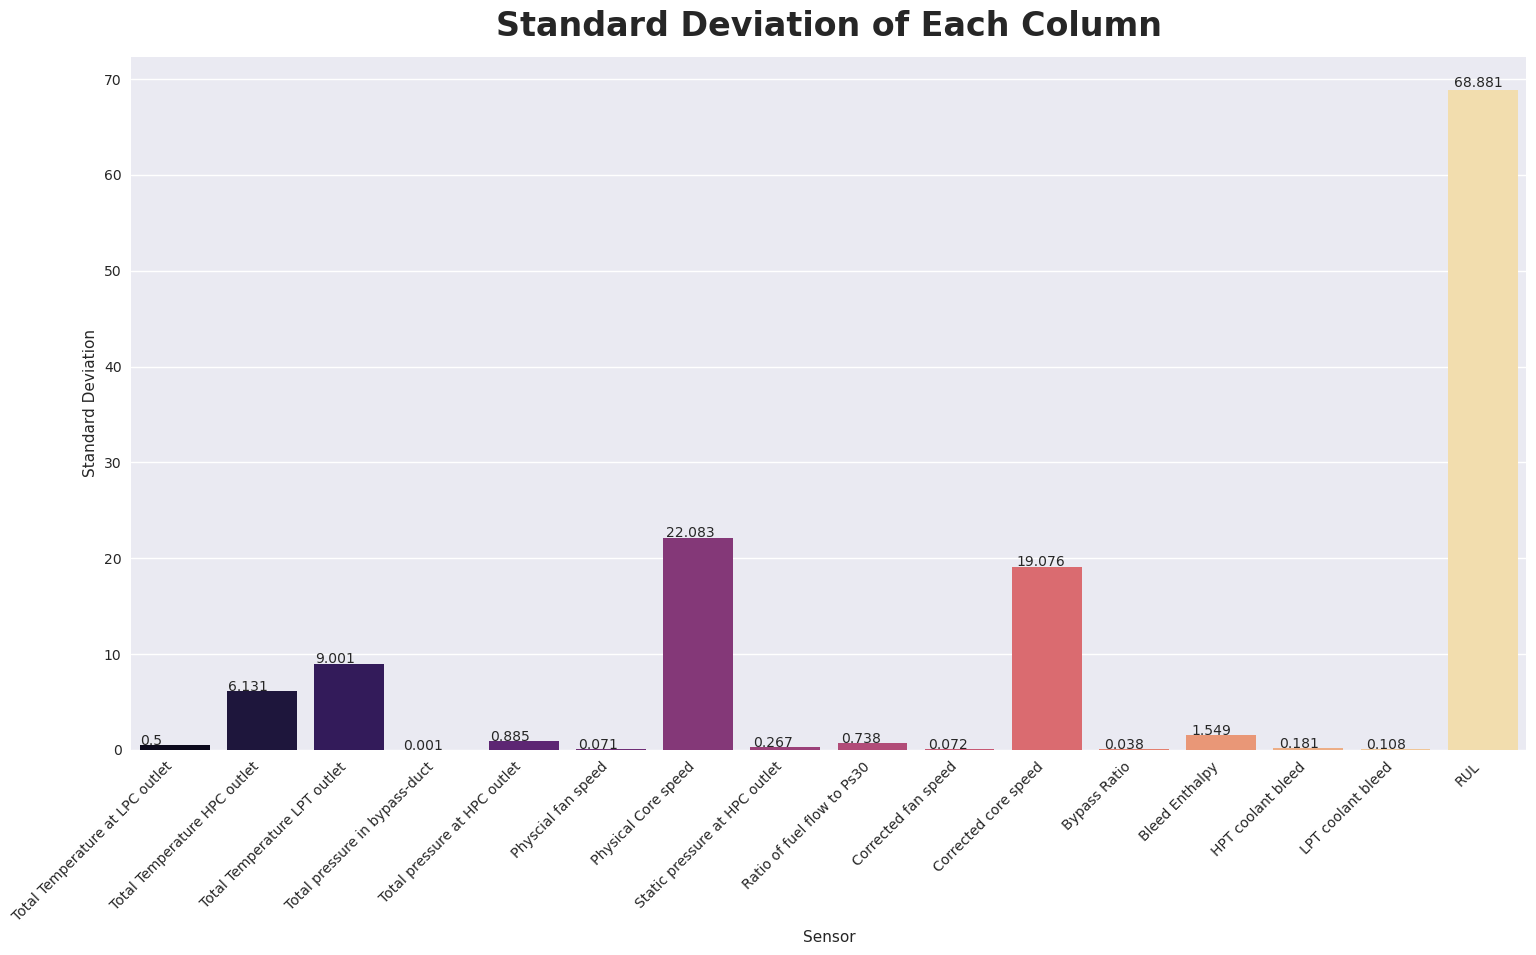

In [119]:
plt.figure(figsize=(18, 9))
subset_stats =train2.agg(['mean', 'std']).T[2:]
ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='magma')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Sensor")
ax.set_ylabel("Standard Deviation")
ax.set_title("Standard Deviation of Each Column", fontweight='bold', fontsize=24, pad=15)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

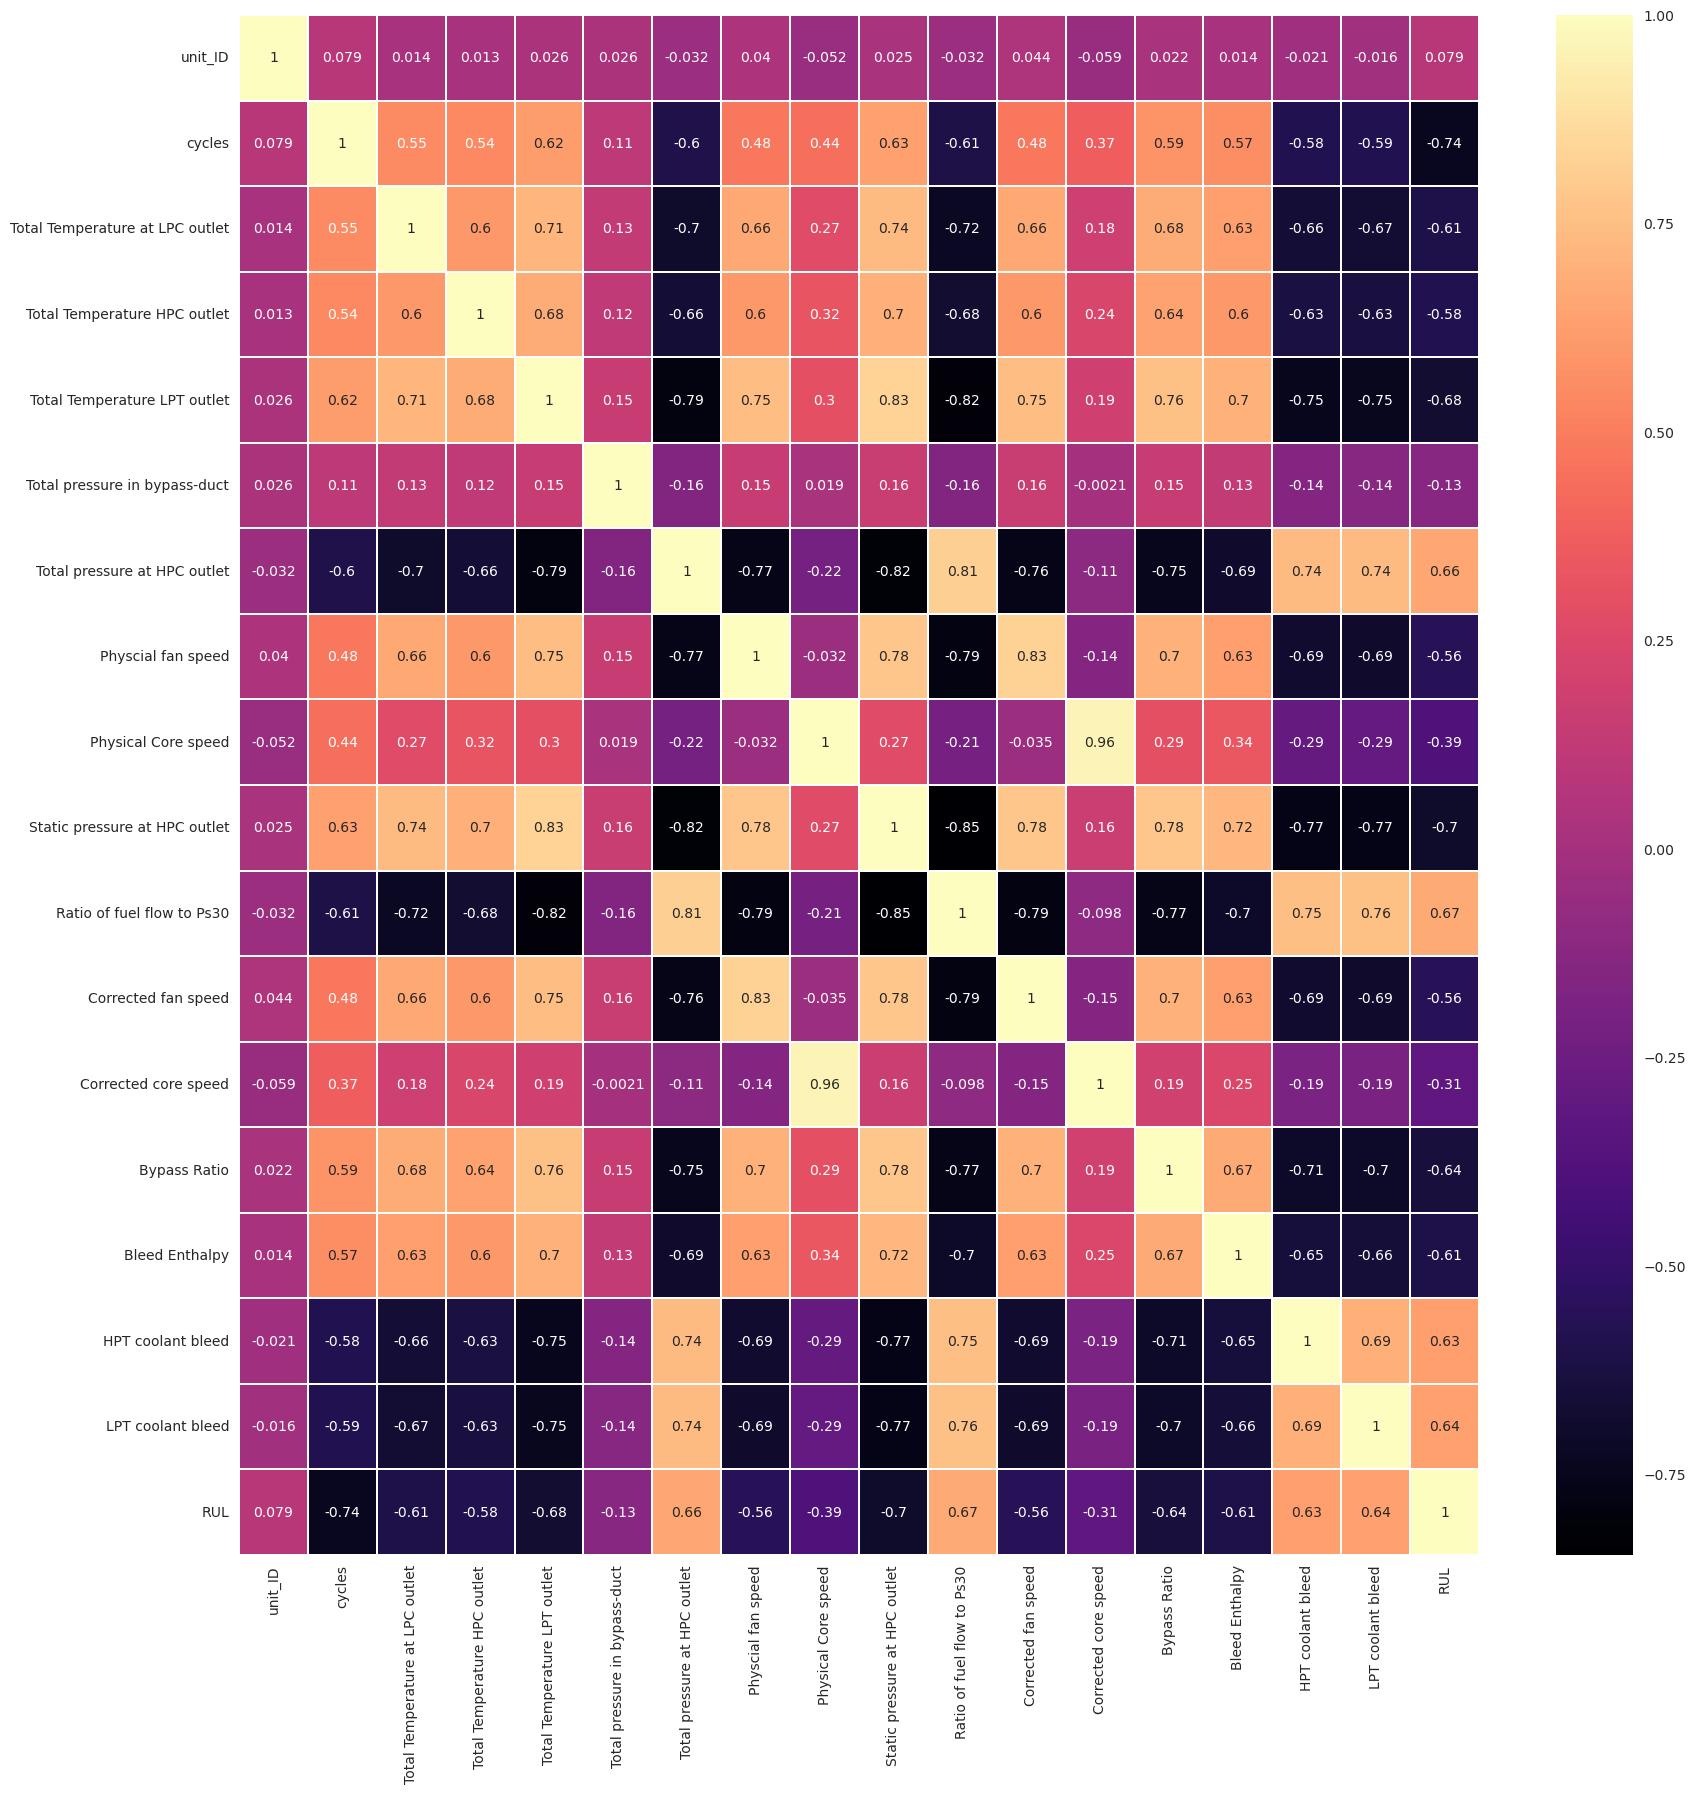

In [120]:
sns.heatmap(train2.corr(),annot=True,cmap='magma',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [121]:
train2

,unit_ID,cycles,Total Temperature at LPC outlet,Total Temperature HPC outlet,Total Temperature LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physcial fan speed,Physical Core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalpy,HPT coolant bleed,LPT coolant bleed,RUL
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


# Data Preperation

We then determine the time to failure (TTF) for every row, which is the number of cycles subtracted from the maximum number of cycles in a particular unit.

In [123]:
train2

,unit_ID,cycles,Total Temperature at LPC outlet,Total Temperature HPC outlet,Total Temperature LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physcial fan speed,Physical Core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalpy,HPT coolant bleed,LPT coolant bleed,RUL
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [131]:
train3 = pd.merge(train2, train2.groupby('unit_ID', as_index=False)['cycles'].max(), how='left', on='unit_ID')
train3 = train3.rename(columns={"cycles_x": "cycles","cycles_y": "maxcycles"}, inplace=True)

In [133]:
train3